In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan, isnan
from os import listdir as listdir, makedirs as makedirs, path as osp, remove as remove, sep as sep, walk as walk
from pandas import (
    CategoricalDtype, DataFrame, Index, NaT, Series, concat, get_dummies, isna, notnull, read_csv, read_excel, to_datetime, to_numeric
)
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import re
import statsmodels.api as sm


## Use the CSV Data from the CACI Logs (Human_Sim_Metrics_Data_4-12-2024)

In [3]:

# In the zip there are 51 folders, (51 JSON, 51 CSV).
# All the files are named appropriated in the folder/csv/json UUID_ParticipantID.
# Some of the internal Participants IDs might be off because the moderator forgot to enter a Participant ID or didn't enter
# the Participant ID correctly so we needed to figure out which participant it was.
# So only utilize the UUID and Participant ID that is on the file name to identify and ignore the internal Participant IDs.
print("\nGet all the Open World logs into one data frame")
csv_stats_df = DataFrame([])
logs_path = osp.join(nu.data_folder, 'logs', 'Human_Sim_Metrics_Data_4-12-2024')
directories_list = listdir(logs_path)
for dir_name in directories_list:
    
    # Add the CSVs to the data frame
    folder_path = osp.join(logs_path, dir_name)
    df = fu.concatonate_logs(logs_folder=folder_path)
    
    session_uuid, participant_id = dir_name.split('_')
    df['session_uuid'] = session_uuid
    df['participant_id'] = int(participant_id)
    
    # Remove numerically-named columns
    columns_list = [x for x in df.columns if not search(r'\d+', str(x))]
    df = df[columns_list]
    
    # Convert 'TRUE' and 'FALSE' to boolean values
    for cn in fu.boolean_columns_list:
        df[cn] = df[cn].map({'TRUE': True, 'FALSE': False, 'True': True, 'False': False})
    
    # Convert the nulls into NaNs
    for cn in df.columns: df[cn] = df[cn].replace(['null', 'nan', 'n'], nan)
    
    # Append the data frame for the current subdirectory to the main data frame and break the participant ID loop
    csv_stats_df = concat([csv_stats_df, df], axis='index')

csv_stats_df = csv_stats_df.reset_index(drop=True).drop_duplicates()
csv_stats_df['csv_file_name'] = csv_stats_df.csv_file_subpath.map(lambda x: str(x).split('/')[-1])

# Check for proper ingestion (duplicate file ingestion, et al)
assert len(csv_stats_df.columns) > 4, "Nothing ingested"
assert csv_stats_df.participant_id.nunique() == 26, f"Participant count should be 26, it's {csv_stats_df.participant_id.nunique()} instead"

# Check that all the rows that have more than one unique value in the file_name column for each value in the session_uuid column
mask_series = (csv_stats_df.groupby('session_uuid').csv_file_subpath.transform(Series.nunique) > 1)
assert not mask_series.any(), "You have duplicate files"

print(csv_stats_df.shape)
display(csv_stats_df.groupby('participant_id').size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))
display(csv_stats_df.sample(4).dropna(axis='columns', how='all').T.sample(5))


Get all the Open World logs into one data frame
(158663, 110)


,record_count
participant_id,
2024202,11231
2024211,10888
2024209,10503
2024224,10365
2024218,10261


,177648,135233,196531,88762
tool_hover_type,SAM Splint,Pulse Oximeter,Gauze,SAM Splint
csv_file_name,c9a8dc60-f61d-44bb-bcb5-6e2466f3c9a0_2024223.csv,922ad146-241a-4ea6-8ff1-413d7e0d16ec_2024202.csv,dfec642f-45c9-4813-91d8-3445d5ca763c_2024213.csv,50b15e40-9860-4574-8ab8-0bd960fe27de_2024220.csv
action_tick,705961,760196,814506,70805
is_scene_aborted,False,False,False,False
session_uuid,c9a8dc60-f61d-44bb-bcb5-6e2466f3c9a0,922ad146-241a-4ea6-8ff1-413d7e0d16ec,dfec642f-45c9-4813-91d8-3445d5ca763c,50b15e40-9860-4574-8ab8-0bd960fe27de


In [4]:

# Modalize separate patient ID columns into one
new_column_name = 'patient_id'
patient_id_columns_list = sorted(set(fu.patient_id_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, patient_id_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
patient_id,
Open World Marine 1 Female Root,2313
Patient V Root,2052
Patient U Root,1900
Patient X Root,1003
patient U Root,992


In [5]:

# Modalize separate patient SORT columns into one
new_column_name = 'patient_sort'
patient_sort_columns_list = sorted(set(fu.patient_sort_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, patient_sort_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
patient_sort,
still,1066
waver,670
walker,336


In [6]:

# Modalize separate injury severity columns into one
new_column_name = 'injury_severity'
injury_severity_columns_list = sorted(set(fu.injury_severity_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, injury_severity_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
injury_severity,
medium,1020
high,966
low,110


In [7]:

# Modalize separate location ID columns into one
new_column_name = 'location_id'
location_id_columns_list = sorted(set(fu.location_id_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, location_id_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
location_id,
"(0.0, 0.0, 0.0)",2675
"(15.1, 0.0, -27.9)",2102
"(-19.6, 0.0, -10.0)",1053
"(-22.5, 0.0, -10.7)",843
"(-3.3, 0.0, 0.0)",824


In [8]:

# Modalize separate injury ID columns into one
new_column_name = 'injury_id'
injury_id_columns_list = sorted(set(fu.injury_id_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, injury_id_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
injury_id,
L Leg Broken,179
R Forearm Burn,151
L Shoulder Broken,138
Unspecified,136
R Shoulder Puncture,131


In [9]:

# Modalize separate injury required procedure columns into one
new_column_name = 'injury_required_procedure'
injury_required_procedure_columns_list = sorted(set(fu.injury_required_procedure_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, injury_required_procedure_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
injury_required_procedure,
burnDressing,539
splint,478
tourniquet,353
woundpack,334
none,162


In [10]:

# Modalize separate patient SALT columns into one
new_column_name = 'patient_salt'
patient_salt_columns_list = sorted(set(fu.patient_salt_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, patient_salt_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
patient_salt,
DELAYED,767
IMMEDIATE,674
EXPECTANT,373
MINIMAL,258



### Truncate the CSV data to only include our patients at the times they were engaged

In [11]:

# Build a dataset of each CSV file and the action tick where CACI patients first appear
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_set = set(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
mask_series = ~csv_stats_df.patient_id.isnull()
assert patients_set.issubset(set(csv_stats_df[mask_series].patient_id)), "Our patients lists are not in the CSVs"
mask_series = csv_stats_df.patient_id.isin(patients_set)
rows_list = []
for csv_file_name, csv_file_name_df in csv_stats_df[mask_series].groupby('csv_file_name'):
    row_dict = {'csv_file_name': csv_file_name}
    action_tick = csv_file_name_df.action_tick.min()
    row_dict['first_occurence'] = action_tick
    rows_list.append(row_dict)
first_occurence_df = DataFrame(rows_list)
print(first_occurence_df.shape)
display(first_occurence_df.sample(5))

(51, 2)


,csv_file_name,first_occurence
28,80f79d45-22fd-479d-b6e2-c62b5778e073_2024204.csv,171508
32,922ad146-241a-4ea6-8ff1-413d7e0d16ec_2024202.csv,145986
47,ddfb4e6e-f7c3-4321-89df-b6208f336318_2024205.csv,17301
26,703b9d0b-7786-4a4b-8a26-7c57d16b785a_2024226.csv,37239
8,23081f6e-875e-44f5-8bd0-edc3905f5c2c_2024201.csv,191822


In [12]:

# From each file, filter out the time before the first appearance of the CACI patients
truncated_df = DataFrame([])
for (csv_file_name, first_occurence), _ in first_occurence_df.groupby(['csv_file_name', 'first_occurence']):
    mask_series = (csv_stats_df.csv_file_name == csv_file_name) & (csv_stats_df.action_tick >= first_occurence)
    df = csv_stats_df[mask_series]
    truncated_df = concat([truncated_df, df], axis='index')
print(truncated_df.shape)
display(truncated_df.sample(4).T)

(137063, 117)


,136260,176208,189878,190268
action_type,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER
action_tick,813409,249311,338006,481154
event_time,2024-03-14 10:31:57,2024-03-22 14:31:18,2024-03-14 15:22:57,2024-03-14 15:25:20
session_uuid,922ad146-241a-4ea6-8ff1-413d7e0d16ec,c9a8dc60-f61d-44bb-bcb5-6e2466f3c9a0,df2fcf88-874b-4cf9-9707-3fa0b30c348f,df2fcf88-874b-4cf9-9707-3fa0b30c348f
csv_file_subpath,Human_Sim_Metrics_Data_4-12-2024/922ad146-241a...,Human_Sim_Metrics_Data_4-12-2024/c9a8dc60-f61d...,Human_Sim_Metrics_Data_4-12-2024/df2fcf88-874b...,Human_Sim_Metrics_Data_4-12-2024/df2fcf88-874b...
...,...,...,...,...
injury_severity,NaN,NaN,NaN,NaN
location_id,NaN,NaN,NaN,NaN
injury_id,NaN,NaN,NaN,NaN
injury_required_procedure,NaN,NaN,NaN,NaN


In [13]:

# Create a list of patients that CACI doesn't care about
mask_series = ~csv_stats_df.patient_id.isin(patients_set) & ~csv_stats_df.patient_id.isnull()
non_patients_list = csv_stats_df[mask_series].patient_id.unique().tolist()
non_patients_list

['Navy Soldier 1 Male', 'Navy Soldier 3 Male', 'Navy Soldier 2 Male', 'Navy Soldier 4 Female', 'patient U Root', 'patient V Root', 'patient W Root', 'patient X Root', 'electrician Root', 'bystander Root', 'Player', 'patient U', 'patient W', 'Simulation Root', 'Patient V Root', 'Patient U Root', 'Patient W Root', 'Adept Victim Root', 'Adept Shooter Root', 'Patient X Root', 'NPC 2 Root', 'NPC 1 Root', 'NPC 3 Root', 'NPC 4 Root', 'Patient V', 'Patient X', 'Patient W', 'Submarine Level Core', 'Open World Civilian 1 Male', 'US Soldier 1 Root', 'Local Soldier 1 Root', 'Open World Marine 2 Male', 'Open World Marine 1 Female', 'Marine 3 Male', 'Civilian 1 Female', 'Marine 4 Male', 'Marine 1 Male', 'Marine 2 Male', 'Civilian 1 Root', 'NPC Root', 'Civilian 2 Root', 'Open World Marine 1 Male', 'Patient U', 'Open World Marine 3 Male', 'Civilian 1', 'Urban Level Core', 'patient X', 'Open World Marine 4 Male', 'Open World Marine 2 Female', 'Local Soldier 1', 'US Soldier 1', 'electrician', 'Open Worl

In [14]:

# Filter out just the patients that CACI doesn't care about
mask_series = ~truncated_df.patient_id.isin(non_patients_list)
truncated_df = truncated_df[mask_series]
print(truncated_df.shape)

(123896, 117)



## Create the Scene Data

In [15]:

# Create the scene data frame precursor
distance_delta_df = fu.get_distance_deltas_data_frame(truncated_df)
print(distance_delta_df.shape)
display(distance_delta_df.sample(5).T)
display(distance_delta_df.groupby('patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

(67, 17)


,51,43,42,29,23
session_uuid,aecfcd56-2262-40a8-9bb8-088f57d46f3f,922ad146-241a-4ea6-8ff1-413d7e0d16ec,922ad146-241a-4ea6-8ff1-413d7e0d16ec,6666ee6b-863b-49d1-8097-97e6aa4fb39d,50b15e40-9860-4574-8ab8-0bd960fe27de
scene_id,0,1,0,0,0
patient_count,4,0,4,5,4
engaged_patient00_metadata,"Open World Civilian 2 Female Root|832747|(0.0,...",NaN,"Open World Civilian 1 Male Root|711909|(8.2, -...",NaN,"Navy Soldier 2 Male Root|432760|(-0.3, -6.6)|w..."
engaged_patient01_metadata,"Open World Marine 2 Male Root|932331|(10.3, -2...",NaN,"Open World Marine 2 Male Root|736441|(10.4, -2...",NaN,"Navy Soldier 1 Male Root|498393|(0.0, 0.0)|sti..."
engaged_patient02_metadata,"Open World Civilian 1 Male Root|991918|(8.5, -...",NaN,Open World Civilian 2 Female Root|805702|(14.4...,NaN,"Navy Soldier 3 Male Root|511124|(-0.3, 3.4)|wa..."
engaged_patient03_metadata,"Open World Marine 1 Female Root|1036525|(0.0, ...",NaN,"Open World Marine 1 Female Root|862629|(14.4, ...",NaN,"Navy Soldier 4 Female Root|552381|(-5.3, -0.1)..."
last_still_engagement,881088.0,NaN,659716.0,-127393.0,482916.0
actual_engagement_distance,56.416832,0.0,11.618757,0.0,16.123302
measure_of_right_ordering,1.0,NaN,-0.172195,NaN,-0.250976


,record_count
patient_count,
0,13
4,41
5,13


In [16]:

# Create the scene stats data frame
rows_list = []
for (session_uuid, scene_id), idx_df in distance_delta_df.groupby(fu.scene_groupby_columns):
    row_dict = list(idx_df.T.to_dict().values())[0]
    
    # mean_patient_count
    patient_count = row_dict.pop('patient_count')
    row_dict.update({'scene_patient_count': patient_count})
    
    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (truncated_df[cn] == eval(cn))
    scene_df = truncated_df[mask_series]
    
    if scene_df.shape[0]:
        row_dict['participant_id'] = scene_df.participant_id.iloc[0]
        
        # Get the count of all the patient injuries
        all_patient_injuries_count = 0
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            all_patient_injuries_count += patient_df.injury_id.nunique()
        row_dict['scene_patient_injuries_count'] = all_patient_injuries_count
        
        # percent_injury_correctly_treated
        correctly_treated_count = fu.get_injury_correctly_treated_count(scene_df)
        row_dict['scene_correctly_treated_count'] = correctly_treated_count
        try: percent_injury_correctly_treated = 100 * correctly_treated_count / all_patient_injuries_count
        except ZeroDivisionError: percent_injury_correctly_treated = nan
        row_dict['scene_percent_injury_correctly_treated'] = percent_injury_correctly_treated
        
        # mean_pulse_taken_count
        pulse_taken_count = fu.get_pulse_taken_count(scene_df)
        row_dict['scene_pulse_taken_count'] = pulse_taken_count
        
        # mean_stills_value
        row_dict['scene_stills_value'] = fu.get_stills_value(scene_df)
        
        # mean_teleport_count
        row_dict['scene_teleport_count'] = fu.get_teleport_count(scene_df)
        
        # mean_time_to_hemorrhage_control_per_patient
        row_dict['scene_time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
        
        # mean_triage_time
        row_dict['scene_triage_time'] = fu.get_triage_time(scene_df)
        
        # total_action_count
        mask_series = scene_df.action_type.isin(fu.action_types_list)
        row_dict['scene_action_count'] = scene_df[mask_series].shape[0]
        
        # total_assessment_count
        mask_series = scene_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['scene_assessment_count'] = scene_df[mask_series].shape[0]
        
        # total_treatment_count
        mask_series = scene_df.action_type.isin(['INJURY_TREATED'])
        row_dict['scene_treatment_count'] = scene_df[mask_series].shape[0]
        
        # total_tag_application_count
        mask_series = scene_df.action_type.isin(['TAG_APPLIED'])
        row_dict['scene_tag_application_count'] = scene_df[mask_series].shape[0]
    
    rows_list.append(row_dict)
scene_stats_df = DataFrame(rows_list).drop_duplicates()
print(scene_stats_df.shape)
display(scene_stats_df.sample(5).T)
display(scene_stats_df.groupby('scene_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

(67, 30)


,8,46,50,2,13,21
session_uuid,220b609b-0e35-454e-9afd-c84cbfa3e3ad,a7ce6f7b-6466-4281-9496-92b640d9d04b,acf74a81-a534-44c7-9cb1-67ec381b5ee0,05e0be07-479a-4ea4-9b90-3fc7b79ef7ff,287389c4-4c48-4483-87c0-6b363b57bde2,4bc46c8c-66e7-463d-b3a1-2a8303af4fd1
scene_id,0,0,1,0,0,0
engaged_patient00_metadata,"Marine 1 Male Root|883896|(7.2, 21.7)|still|No...","Navy Soldier 2 Male Root|517276|(-0.1, -5.5)|w...",NaN,"Marine 1 Male Root|875377|(7.2, 21.7)|still|No...","Open World Marine 1 Male Root|545140|(1.9, 2.2...",NaN
engaged_patient01_metadata,"Marine 4 Male Root|996346|(10.1, 18.9)|waver|N...","Navy Soldier 3 Male Root|600866|(-0.6, 3.9)|wa...",NaN,"Marine 4 Male Root|925997|(10.2, 18.8)|still|N...","Open World Marine 4 Male Root|586609|(0.8, 1.1...",NaN
engaged_patient02_metadata,"Marine 2 Male Root|1055180|(14.1, 9.6)|waver|N...","Navy Soldier 1 Male Root|661042|(-0.3, -0.1)|s...",NaN,NaN,NaN,NaN
engaged_patient03_metadata,"Marine 3 Male Root|1092407|(11.3, 10.4)|waver|...","Navy Soldier 4 Female Root|695443|(-4.2, -0.5)...",NaN,NaN,NaN,NaN
last_still_engagement,830314.0,646894.0,NaN,896972.0,568045.0,-115332.0
actual_engagement_distance,22.111707,17.344982,0.0,4.172529,1.555635,0.0
measure_of_right_ordering,0.977149,0.451136,NaN,NaN,NaN,NaN
unengaged_patient00_metadata,NaN,NaN,NaN,Civilian 1 Female Root|-99999|None|still|None|...,Open World Marine 2 Female Root|-99999|None|wa...,Open World Marine 1 Male Root|-99999|None|stil...


,record_count
scene_patient_count,
0,13
4,41
5,13


In [17]:

# Add the sim environment column
new_column_name = 'encounter_layout'
encounter_layouts_list = ['Desert', 'Jungle', 'Submarine', 'Urban']
for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
    for env_str in encounter_layouts_list:
        patients_list = eval(f'{env_str.lower()}_patients_list')
        if all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list)):
            mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
            scene_stats_df.loc[mask_series, new_column_name] = env_str
display(scene_stats_df.groupby([new_column_name, 'scene_patient_count'], dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

,,record_count
encounter_layout,scene_patient_count,
Desert,4,15
Jungle,4,13
Submarine,4,13
Urban,5,13
NaN,0,13



### Add the mean % accurate tagging column

In [18]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_data_frame(truncated_df, groupby_column='participant_id')
assert tag_to_salt_df.max_salt.dropna().shape[0] > 0, "You have to add the patient_salt column to truncated_df"
display(tag_to_salt_df.sample(5))

,session_uuid,scene_id,patient_id,participant_id,patient_count,last_tag,max_salt,predicted_tag,is_tag_correct
141,6db9446c-2cd4-41b4-be8d-be5ccbbc6e05,0,Open World Civilian 2 Female Root,2024217,1,NaN,EXPECTANT,gray,False
99,2e8f6555-a7fa-4b54-8132-c030d697b4ad,0,Open World Marine 3 Male Root,2024212,1,NaN,IMMEDIATE,red,False
185,c99de80f-15cc-45cb-aa64-5af0f2f118ca,0,Open World Marine 1 Female Root,2024222,1,NaN,DELAYED,yellow,False
137,1995e7ef-ef02-4fc1-b1ab-f137dbf69d48,0,Marine 2 Male Root,2024217,1,NaN,IMMEDIATE,red,False
111,fc676b00-9559-467d-adbb-696dd6e9fb08,0,Open World Civilian 2 Female Root,2024213,1,gray,EXPECTANT,gray,True


In [19]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='participant_id')
display(correct_count_by_tag_df.sample(5))

,session_uuid,scene_id,participant_id,percentage_tag_correct
5,1995e7ef-ef02-4fc1-b1ab-f137dbf69d48,0,2024217,0.0
14,37a554ee-fc49-4730-819c-2d97727bb0b7,0,2024218,25.0
2,05e0be07-479a-4ea4-9b90-3fc7b79ef7ff,0,2024225,40.0
36,9f3bb117-3a4b-4bc7-9237-e2d9920d5333,0,2024227,0.0
21,50b15e40-9860-4574-8ab8-0bd960fe27de,0,2024220,25.0


In [20]:

# Group the scene stats by participant ID to get the tagging accuracy measure
for participant_id, idx_df in scene_stats_df.groupby('participant_id'):
    
    # mean_percent_accurate_tagging
    mask_series = (correct_count_by_tag_df.participant_id == participant_id)
    scene_stats_df.loc[idx_df.index, 'mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()


### Add the treated-expectant count column

In [21]:

# Loop through each patient to build the max salt and treated-expectant measures
assert 'patient_salt' in truncated_df.columns, "You have to add the patient_salt column to truncated_df"
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in truncated_df.groupby(fu.patient_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
    row_dict['max_salt'] = fu.get_max_salt(patient_df, session_uuid=session_uuid, scene_id=scene_id, random_patient_id=patient_id)[1]
    if (row_dict['max_salt'] == 'EXPECTANT'):
        mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
        row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
    else: row_dict['treated_expectant'] = nan
    rows_list.append(row_dict)
treated_expectant_df = DataFrame(rows_list)
display(treated_expectant_df.sample(5))

,session_uuid,scene_id,patient_id,max_salt,treated_expectant
145,8839e3b8-be5e-4878-8aaf-26c656ae2270,0,Open World Marine 4 Male Root,EXPECTANT,no
179,b5989edc-8348-4b84-b649-87fc4f1cca53,0,Open World Civilian 2 Female Root,EXPECTANT,no
55,287389c4-4c48-4483-87c0-6b363b57bde2,0,Open World Marine 4 Male Root,EXPECTANT,yes
84,4bc46c8c-66e7-463d-b3a1-2a8303af4fd1,0,Open World Marine 2 Female Root,IMMEDIATE,NaN
65,385032e9-9801-4dcf-a841-b3703a0d9acd,0,Marine 1 Male Root,EXPECTANT,no


In [22]:

# Loop through each scene to build the treated-expectant counts
for (session_uuid, scene_id), scene_df in treated_expectant_df.groupby(fu.scene_groupby_columns):
    mask_series = (scene_df.treated_expectant == 'yes')
    
    # treated_expectant_count
    treated_expectant_count = mask_series.sum()
    mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
    scene_stats_df.loc[mask_series, 'treated_expectant_count'] = treated_expectant_count

In [23]:

# Add the survey columns
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text']
if any(map(lambda x: x not in scene_stats_df.columns, survey_columns)):
    file_path = osp.join(nu.data_folder, 'xlsx', 'participant_data_0420.xlsx')
    participant_data_df = read_excel(file_path).rename(columns={'ParticipantID': 'participant_id'})
    print(participant_data_df.shape)
    display(participant_data_df.sample(12).T)
    
    print("\nColumns to merge the participant data with the scene stats on:")
    on_columns = sorted(set(scene_stats_df.columns).intersection(set(participant_data_df.columns)))
    assert on_columns, "You have nothing to merge the participant dataset with the scene stats on"
    print(on_columns)

    print("\nThe participant data columns we want to have in the merge:")
    survey_set = set(on_columns + survey_columns)
    all_set = set(participant_data_df.columns)
    assert survey_set.issubset(all_set), f"You're missing {survey_set.difference(all_set)} from participant_data_0420.xlsx"
    columns_list = sorted(survey_set)
    print(columns_list)
    
    # mean_AD_KDMA_Sim
    # mean_AD_KDMA_Text
    # mean_PropTrust
    # mean_ST_KDMA_Sim
    # mean_ST_KDMA_Text
    df = participant_data_df[columns_list]
    print(scene_stats_df.shape)
    print(df.shape)
    scene_stats_df = scene_stats_df.merge(df, how='left', on=on_columns)
    print(scene_stats_df.shape)
    display(scene_stats_df.groupby(survey_columns, dropna=False).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
        'record_count', ascending=False
    ).head())

(26, 163)


,12,25,22,17,21,24,19,0,9,20,18,13
participant_id,2024214,2024227,2024224,2024219,2024223,2024226,2024221,2024201,2024211,2024222,2024220,2024215
Date,2024-03-20 00:00:00,2024-04-05 00:00:00,2024-04-05 00:00:00,2024-03-20 00:00:00,2024-03-22 00:00:00,2024-04-05 00:00:00,2024-03-24 00:00:00,2024-03-14 00:00:00,2024-03-20 00:00:00,2024-03-23 00:00:00,2024-03-20 00:00:00,2024-03-20 00:00:00
MedRole,NaN,5.0,3.0,6.0,NaN,3.0,6.0,6.0,2.0,6.0,1.0,6.0
MedExp,NaN,2.0,2.0,0.0,NaN,1.0,0.0,2.0,1.0,0.0,0.0,0.0
MilitaryExp,NaN,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ST_Align_LOW_text,0.34797,0.38765,0.386633,0.322435,0.394332,0.229217,0.371962,0.313272,0.348785,0.288707,0.387793,0.31783
ST_Align_HIGH_sim,0.345243,0.272968,0.396259,0.383005,0.317089,0.387452,0.368191,0.367164,0.405731,0.400454,0.395126,0.361009
ST_Align_LOW_sim,0.204622,0.362257,0.265481,0.333896,0.350421,0.210766,0.325467,0.274403,0.241932,0.231824,0.320934,0.245353
ST_Align_HIGH_Four,0.356846,0.291602,0.353326,0.353369,0.304981,0.435811,0.388033,0.394188,0.33661,0.465159,0.399851,0.306278



Columns to merge the participant data with the scene stats on:
['participant_id']

The participant data columns we want to have in the merge:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'participant_id']
(67, 33)
(26, 6)
(67, 38)


record_count
AD_KDMA_Sim AD_KDMA_Text PropTrust ST_KDMA_Sim ST_KDMA_Text              
0.341667    0.416667     3.666667  0.558333    0.421212                 5
0.500000    0.516667     4.333333  0.538462    0.319750                 4
0.466667    0.466667     2.333333  0.546154    0.278912                 4
            0.316667     4.333333  0.553846    0.325920                 3
            0.516667     3.333333  0.561538    0.380940                 3


### Truncate the scene data to only include our patients at the times they were engaged

In [24]:

# Filter out the unnamed layouts
mask_series = scene_stats_df.encounter_layout.isin(encounter_layouts_list)
pre_count = scene_stats_df.shape[0]
scene_stats_df = scene_stats_df[mask_series]
print(f"\nFiltered out {pre_count - scene_stats_df.shape[0]} unnamed encounter layouts")
display(scene_stats_df.groupby([new_column_name, 'scene_patient_count'], dropna=False).size().to_frame().rename(columns={0: 'record_count'}))


Filtered out 13 unnamed encounter layouts


,,record_count
encounter_layout,scene_patient_count,
Desert,4,15
Jungle,4,13
Submarine,4,13
Urban,5,13


In [25]:

# Check for zero teleports
mask_series = (scene_stats_df.scene_teleport_count < 1)
print(f"\nThere are {scene_stats_df[mask_series].shape[0]} out of {scene_stats_df.shape[0]} scenes with no teleports")


There are 0 out of 54 scenes with no teleports


In [26]:

# Save the scene stats dataset
nu.save_data_frames(truncated_scene_stats_df=scene_stats_df, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/truncated_scene_stats_df.csv



## Create the ANOVA Dataframe

In [27]:

# Get the columns to merge the scene stats dataset with the CSV stats on
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)


Columns to merge the scene stats dataset with the CSV stats on:
['participant_id', 'scene_id', 'session_uuid']


In [28]:

# Get the scene stats dataset columns we want to have in the merge
print('\nThe scene stats dataset columns we want to have in the merge:')
mean_analysis_columns = sorted([
    'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count',
    'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time', 'scene_patient_count', 'mean_percent_accurate_tagging'
] + survey_columns)
sum_analysis_columns = sorted([
    'scene_action_count', 'scene_assessment_count', 'scene_treatment_count', 'scene_tag_application_count', 'treated_expectant_count'
])
analysis_set = set(mean_analysis_columns + sum_analysis_columns)
all_set = set(scene_stats_df.columns)
assert analysis_set.issubset(all_set), f"You're missing {analysis_set.difference(all_set)} from your analysis_columns"
print(analysis_set)


The scene stats dataset columns we want to have in the merge:
{'AD_KDMA_Sim', 'ST_KDMA_Text', 'scene_stills_value', 'scene_teleport_count', 'scene_triage_time', 'scene_tag_application_count', 'AD_KDMA_Text', 'scene_pulse_taken_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_treatment_count', 'ST_KDMA_Sim', 'scene_percent_injury_correctly_treated', 'PropTrust', 'scene_action_count', 'mean_percent_accurate_tagging', 'scene_assessment_count', 'treated_expectant_count', 'scene_patient_count'}


In [29]:

# Merge the scene stats with the CSV stats
print("\nMerge the scene stats with the CSV stats")
columns_list = on_columns + mean_analysis_columns + sum_analysis_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
df = scene_stats_df[columns_list]
print(csv_stats_df.shape)
print(df.shape)
merge_df = csv_stats_df.merge(df, on=on_columns, how='left').drop_duplicates()
print(merge_df.shape)
display(merge_df.sample(4).T)
display(merge_df.groupby('scene_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))


Merge the scene stats with the CSV stats
(158663, 117)
(54, 21)
(158663, 135)


,108523,128770,110809,100271
action_type,TOOL_HOVER,TRIAGE_LEVEL_WALK_IF_CAN,PLAYER_LOCATION,TOOL_HOVER
action_tick,88529,813511,155154,76124
event_time,2024-03-14 10:19:52,2024-03-14 16:13:14,2024-04-05 11:18:06,2024-04-05 10:46:04
session_uuid,922ad146-241a-4ea6-8ff1-413d7e0d16ec,b5989edc-8348-4b84-b649-87fc4f1cca53,a3a7727b-dd25-4e78-8d63-e66573f5077e,8b6c4aed-0983-4a76-99fb-cec08dc26b92
csv_file_subpath,Human_Sim_Metrics_Data_4-12-2024/922ad146-241a...,Human_Sim_Metrics_Data_4-12-2024/b5989edc-8348...,Human_Sim_Metrics_Data_4-12-2024/a3a7727b-dd25...,Human_Sim_Metrics_Data_4-12-2024/8b6c4aed-0983...
...,...,...,...,...
scene_action_count,2003.0,3287.0,1817.0,5017.0
scene_assessment_count,23.0,10.0,7.0,4.0
scene_tag_application_count,4.0,4.0,1.0,1.0
scene_treatment_count,15.0,8.0,3.0,3.0


,record_count
scene_patient_count,
4.0,116458
5.0,42150
NaN,55


In [30]:

# Get the merge dataset columns we want to have in the groupby
print('\nThe merge dataset columns we want to have in the groupby:')
columns_list = sorted(set(
    on_columns + mean_analysis_columns + sum_analysis_columns
).intersection(set(merge_df.columns)))
print(columns_list)


The merge dataset columns we want to have in the groupby:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'participant_id', 'scene_action_count', 'scene_assessment_count', 'scene_id', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_tag_application_count', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_treatment_count', 'scene_triage_time', 'session_uuid', 'treated_expectant_count']


In [31]:

# Get the numeric columns we want to take the mean of
print("\nThe numeric columns we want to take the mean of:")
df = merge_df[on_columns + mean_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the mean analysis columns"
mean_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(mean_numeric_columns)


The numeric columns we want to take the mean of:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time']


In [32]:

# Get the numeric columns we want to take the sum of
print("\nThe numeric columns we want to take the sum of:")
df = merge_df[on_columns + sum_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the sum analysis columns"
sum_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(sum_numeric_columns)


The numeric columns we want to take the sum of:
['scene_action_count', 'scene_assessment_count', 'scene_tag_application_count', 'scene_treatment_count', 'treated_expectant_count']


In [33]:

# Get the other columns we do not want to take the mean or sum of
print("\nThe other columns we do not want to take the mean or sum of:")
other_columns = sorted(set(on_columns + mean_analysis_columns + sum_analysis_columns).difference(set(
    mean_numeric_columns + sum_numeric_columns
)))
print(other_columns)


The other columns we do not want to take the mean or sum of:
['participant_id', 'scene_id', 'session_uuid']


In [34]:

# Get the means and sums datasets and the columns to merge the summed half of the merge with the meaned half of the merge on
means_df = merge_df[mean_numeric_columns+on_columns].groupby(on_columns).mean().reset_index(drop=False).rename(
    columns={cn: 'mean_'+cn.replace('mean_', '').replace('scene_', '') for cn in mean_numeric_columns}
).dropna(axis='columns', how='all')
# display(means_df.sample(7).T)
# display(means_df.groupby('mean_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))
sums_df = merge_df[sum_numeric_columns+on_columns].groupby(on_columns).sum().reset_index(drop=False).rename(
    columns={cn: 'sum_'+cn.replace('sum_', '').replace('scene_', '') for cn in sum_numeric_columns}
).dropna(axis='columns', how='all')
# display(sums_df.sample(7).T)
print("\nColumns to merge the summed half of the merge with the meaned half of the merge on:")
on_columns = sorted(set(means_df.columns).intersection(set(sums_df.columns)))
print(on_columns)
print(means_df.shape)
print(sums_df.shape)
left_df = means_df.merge(sums_df, on=on_columns, how='outer').drop_duplicates()
print(left_df.shape)
# display(left_df.sample(7).T)
# display(left_df.groupby('mean_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))


Columns to merge the summed half of the merge with the meaned half of the merge on:
['participant_id', 'scene_id', 'session_uuid']
(68, 16)
(68, 8)
(68, 21)


In [35]:

# Get the columns to merge the unaggregated half of the merge with the aggregated half of the merge on
right_df = merge_df[other_columns].drop_duplicates().dropna(axis='columns', how='all')
print(right_df.shape)
display(right_df.sample(5))
print("\nColumns to merge the unaggregated half of the merge with the aggregated half of the merge on:")
on_columns = sorted(set(left_df.columns).intersection(set(right_df.columns)))
print(on_columns)

(68, 3)


,participant_id,scene_id,session_uuid
137100,2024222,0,c99de80f-15cc-45cb-aa64-5af0f2f118ca
39165,2024212,0,2e8f6555-a7fa-4b54-8132-c030d697b4ad
94314,2024227,0,84c92e21-764b-435b-9e55-0f12f60383fc
40329,2024218,0,37a554ee-fc49-4730-819c-2d97727bb0b7
156576,2024213,0,fc676b00-9559-467d-adbb-696dd6e9fb08



Columns to merge the unaggregated half of the merge with the aggregated half of the merge on:
['participant_id', 'scene_id', 'session_uuid']


In [36]:

# Merge the unaggregated half of the merge with the aggregated half
print(
    "\nAggregate the data from the merged datasets and group by participant, session,"
    " and scene to get the means and sums of the numeric columns"
)
print(left_df.shape)
print(right_df.shape)
anova_df = left_df.merge(right_df, on=on_columns, how='outer').drop_duplicates()
print(anova_df.shape)
display(anova_df.sample(7).T)
display(anova_df.groupby('mean_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))
assert set(
    ['mean_'+cn for cn in survey_columns]
).issubset(set(anova_df.columns)), "You've lost acces to the survey columns (PropTrust, et al)"
assert len(anova_df.groupby(
    ['participant_id', 'scene_id', 'session_uuid']
).groups.keys()) == anova_df.shape[0], "You have duplicate rows in anova_df"


Aggregate the data from the merged datasets and group by participant, session, and scene to get the means and sums of the numeric columns
(68, 21)
(68, 3)
(68, 21)


,10,49,62,56,20,52,31
participant_id,2024203,2024220,2024225,2024222,2024207,2024221,2024213
scene_id,1,0,0,0,0,0,0
session_uuid,acf74a81-a534-44c7-9cb1-67ec381b5ee0,287389c4-4c48-4483-87c0-6b363b57bde2,05e0be07-479a-4ea4-9b90-3fc7b79ef7ff,c99de80f-15cc-45cb-aa64-5af0f2f118ca,04f80090-9e61-431d-8473-dccb75fed04d,6666ee6b-863b-49d1-8097-97e6aa4fb39d,dfec642f-45c9-4813-91d8-3445d5ca763c
mean_AD_KDMA_Sim,NaN,0.466667,0.416667,0.533333,0.416667,0.241667,0.416667
mean_AD_KDMA_Text,NaN,0.516667,0.366667,0.366667,0.316667,0.416667,0.416667
mean_PropTrust,NaN,3.333333,4.333333,4.0,4.0,3.666667,4.0
mean_ST_KDMA_Sim,NaN,0.561538,0.543182,0.529807,0.492308,0.532692,0.5
mean_ST_KDMA_Text,NaN,0.38094,0.480869,0.529864,0.321641,0.431511,0.398858
mean_percent_accurate_tagging,NaN,12.5,32.5,42.5,37.5,12.5,55.0
mean_patient_count,NaN,4.0,5.0,4.0,4.0,5.0,5.0


,record_count
mean_patient_count,
4.0,41
5.0,13
NaN,14


In [37]:

# Add the sim environment back in
new_column_name = 'encounter_layout'
if new_column_name not in anova_df.columns:
    print("\nAdd the sim environment back in")
    on_columns = sorted(set(anova_df.columns).intersection(set(scene_stats_df.columns)))
    columns_list = on_columns + [new_column_name]
    assert set(columns_list).issubset(set(scene_stats_df.columns)), f"You've lost acces to the {new_column_name} column"
    df = scene_stats_df[columns_list]
    print(anova_df.shape)
    print(df.shape)
    anova_df = anova_df.merge(
        df, on=on_columns, how='left'
    )
    print(anova_df.shape)
    display(anova_df.groupby([new_column_name, 'mean_patient_count'], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ).sort_values('record_count', ascending=False))


Add the sim environment back in
(68, 21)
(54, 5)
(68, 22)


,,record_count
encounter_layout,mean_patient_count,
Desert,4.0,15
NaN,NaN,14
Jungle,4.0,13
Submarine,4.0,13
Urban,5.0,13


In [38]:

# Filter out the unnamed layouts
mask_series = anova_df.encounter_layout.isin(encounter_layouts_list)
pre_count = anova_df.shape[0]
anova_df = anova_df[mask_series]
print(f"\nFiltered out {pre_count - anova_df.shape[0]} unnamed encounter layouts")
display(anova_df.groupby(['encounter_layout', 'mean_patient_count'], dropna=False).size().to_frame().rename(
    columns={0: 'record_count'}
).sort_values('record_count', ascending=False))


Filtered out 14 unnamed encounter layouts


,,record_count
encounter_layout,mean_patient_count,
Desert,4.0,15
Jungle,4.0,13
Submarine,4.0,13
Urban,5.0,13


In [39]:

# Check for low patient counts
mask_series = (anova_df.mean_patient_count < 4)
print(f"\nThere are {anova_df[mask_series].shape[0]} out of {anova_df.shape[0]} participations with low patient counts")


There are 0 out of 54 participations with low patient counts


In [40]:

# Store the results
columns_list = anova_df.columns.tolist()
nu.save_data_frames(truncated_anova_df=anova_df[columns_list], verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/truncated_anova_df.csv


In [41]:

# Get statistics using OSU format
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
description_df = nu.get_statistics(anova_df, columns_list).T
assert float(description_df.loc['mean_patient_count', 'min']) >= 4.0, "There are not less than 4 patients in any scene"

# Calculate range and IQR
description_df['range'] = description_df['max'] - description_df['min']
description_df['IQR'] = description_df['75%'] - description_df['25%']

# Define the index list
index_list = ['min', 'median', 'max', 'IQR', 'range', 'mean', 'SD']

# Set formatting to prevent scientific notation (assuming numeric columns)
description_df = description_df[index_list].applymap('{:.4f}'.format)  # Format as floats with 4 decimals

# Save and show the description data frame
nu.save_data_frames(description_df=description_df, verbose=True)
display(description_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/description_df.csv


,min,median,max,IQR,range,mean,SD
mean_AD_KDMA_Sim,0.1750,0.4417,0.8000,0.1333,0.6250,0.4230,0.1082
mean_AD_KDMA_Text,0.1417,0.4167,0.6250,0.1000,0.4833,0.4083,0.0927
mean_PropTrust,0.0000,4.0000,4.3333,0.3333,4.3333,3.6275,0.9059
mean_ST_KDMA_Sim,0.3615,0.5538,0.6434,0.0650,0.2818,0.5525,0.0610
mean_ST_KDMA_Text,0.2226,0.3809,0.5691,0.1188,0.3466,0.3778,0.0854
mean_percent_accurate_tagging,0.0000,28.7500,75.0000,29.8750,75.0000,31.1111,20.3000
mean_patient_count,4.0000,4.0000,5.0000,0.0000,1.0000,4.2407,0.4315
mean_percent_injury_correctly_treated,0.0000,40.0641,85.0000,44.2353,85.0000,37.2691,26.5480
mean_pulse_taken_count,0.0000,6.0000,26.0000,9.7500,26.0000,8.1111,7.6422
mean_stills_value,0.0000,1.0000,1.0000,1.0000,1.0000,0.6852,0.4688



# Plot the Correlations

In [42]:

# Define a means to plot a correlation graph
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

def plot_correlation_graph(correlations, title_str='Correlation Matrix of ??', fig=None, ax=None):
    
    # Plotting the correlation matrix using matplotlib
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=-1, vmax=1)

    # Create the heatmap
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(correlations, cmap=cmap, norm=norm)

    # Add a color bar
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(correlations.columns)))
    ax.set_yticks(np.arange(len(correlations.columns)))
    ax.set_xticklabels(correlations.columns)
    ax.set_yticklabels(correlations.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')

    # Add text annotations.
    for (i, j), val in np.ndenumerate(correlations):
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=84/correlations.shape[0])
    plt.title(title_str)
    plt.show()

In [43]:

# Plot the correlations of all the numeric columns in the ANOVA dataset
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
# columns_list = ['mean_'+cn for cn in survey_columns]
df = anova_df[columns_list]
correlations_df = df.corr().round(3)
display(correlations_df.sample(4).T)

,mean_ST_KDMA_Sim,mean_AD_KDMA_Sim,sum_tag_application_count,mean_PropTrust
mean_AD_KDMA_Sim,-0.277,1.000,-0.021,0.125
mean_AD_KDMA_Text,0.370,-0.058,0.044,-0.555
mean_PropTrust,-0.168,0.125,-0.034,1.000
mean_ST_KDMA_Sim,1.000,-0.277,0.266,-0.168
mean_ST_KDMA_Text,0.262,-0.389,0.044,0.111
mean_percent_accurate_tagging,0.106,0.173,0.596,-0.032
mean_patient_count,0.112,-0.097,0.251,0.076
mean_percent_injury_correctly_treated,0.308,-0.093,0.659,-0.305
mean_pulse_taken_count,0.258,0.022,0.603,-0.242
mean_stills_value,0.089,0.040,-0.216,0.031


Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/correlations_df.csv


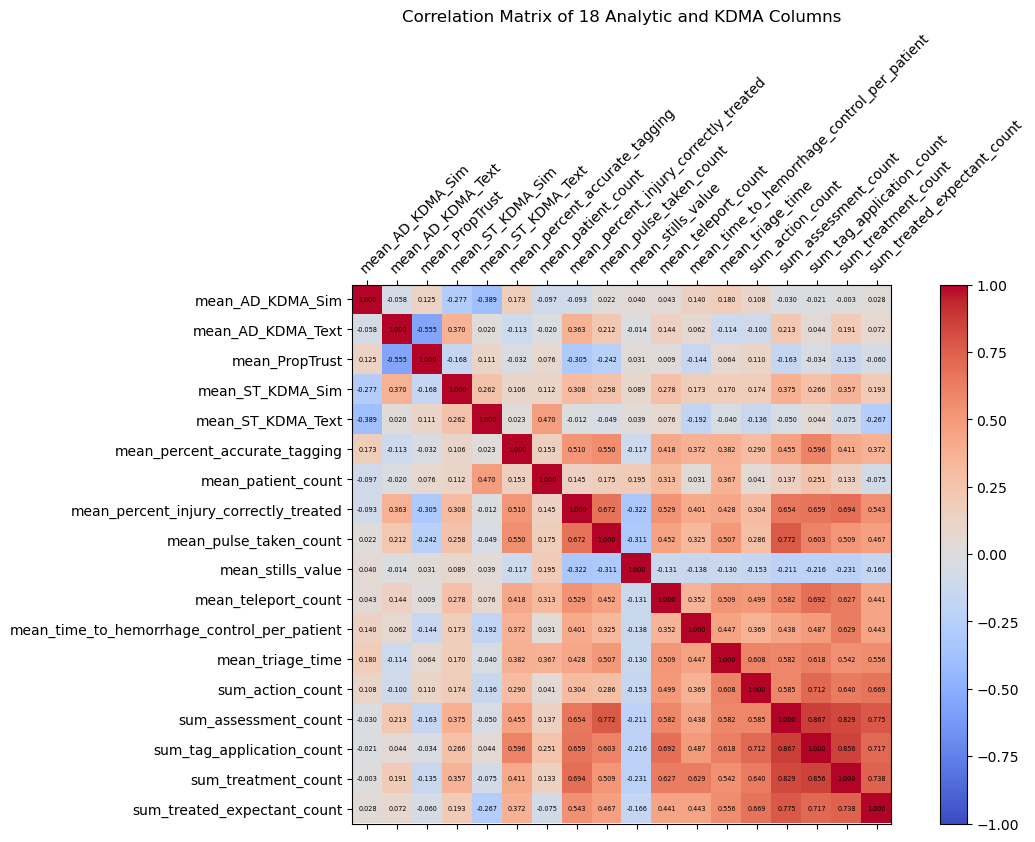

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/png/correlation_matrix_of_18_analytic_and_kdma_columns.png
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/svg/correlation_matrix_of_18_analytic_and_kdma_columns.svg


In [44]:

import os

nu.save_data_frames(correlations_df=correlations_df, verbose=True)
fig_height = 7
fig_size=(nu.twitter_aspect_ratio*fig_height, fig_height)
fig, ax = plt.subplots(figsize=fig_size)
title_str = "Correlation Matrix of 18 Analytic and KDMA Columns"
plot_correlation_graph(correlations_df, title_str=title_str, fig=fig, ax=ax)
dir_names_list=['png', 'svg']
for dir_name in dir_names_list:
    try:
        dir_path = osp.join(nu.saves_folder, dir_name)
        os.makedirs(name=dir_path, exist_ok=True)
        file_path = osp.join(dir_path, '{}.{}'.format(re.sub('[^A-Za-z0-9]+', '_', title_str).lower(), dir_name))
        if osp.exists(file_path): os.remove(file_path)
        print(f'Saving to {osp.abspath(file_path)}')
        fig.savefig(file_path, bbox_inches='tight')
    except Exception as e:
        print(print(f'{e.__class__} error saving the figure as a {dir_name}: {str(e).strip()}'))